# Regularization Techniques


Estimated time needed: **60** minutes

The purpose of Regularization techniques is to reduce the degree of overfitting that can occur in Regression models. Overfitting leads to poor ability of the model to make predictions on the new, unseen data. As we saw in the previous Regression Lessons, with a creation of extra features, such as through polynomial regression, a model can become easily overfit. To reduce the overfitting, we can regularize the model, or in other words, we can decrease its degrees of freedom. A simple way to regularize polynomial model is to reduce the number of polynomial degrees. For a linear regression model, regularization is typically achieved by constraining the weights of the model. Regularizer imposes a penalty on the size of the coefficients of the model.

In this lab, we will cover three types of regularizers:

*   Ridge regression
*   Lasso regression
*   Elastic Net

Each one has its own advantages and disadvantages. Lasso will eliminate many features and reduce overfitting in your linear model. Ridge will reduce the impact of the features that are not important in predicting your target. Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

The common features of all these regularizers include using cross-validation to select hyperparameters and applying data normalization to improve the performance.

## Objectives

After completing this lab you will be able to:

*   Understand the advantages and disadvantages of Ridge, Lasso and Elastic Net Regressions
*   Apply Ridge, Lasso and Elastic Net Regressions
*   Perform  hyperparameters Grid Search on a model using validation data


In [90]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA



In [91]:
def get_R2_features(model,test=True):
    #X: global
    features=list(X)
    features.remove("three")

    R_2_train=[]
    R_2_test=[]

    for feature in features:
        model.fit(X_train[[feature]],y_train)

        R_2_test.append(model.score(X_test[[feature]],y_test))
        R_2_train.append(model.score(X_train[[feature]],y_train))

    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )

In [92]:
def plot_coef(X,model,name=None):


    plt.bar(X.columns[2:],abs(model.coef_[2:]))
    plt.xticks(rotation=90)
    plt.ylabel("$coefficients$")
    plt.title(name)
    plt.show()
    print("R^2 on training  data ",model.score(X_train, y_train))
    print("R^2 on testing data ",model.score(X_test,y_test))


In [93]:
def  plot_dis(y,yhat):

    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

## **Reading and understanding our data**


For this lab, we will be using the car sales dataset, hosted on IBM Cloud object storage. The dataset contains all the information about cars, the name of the manufacturer, the year it was launched, all car technical parameters, and the sale price. This dataset has already been pre-cleaned and encoded (using one-hot and label encoders) in the Linear Regression Notebook.


In [94]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/encoded_car_data.csv')
data.head()

,diesel,gas,std,turbo,convertible,hardtop,hatchback,sedan,wagon,4wd,...,wheelbase,curbweight,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg,price
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,13495.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,16500.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,94.5,2823.0,152.0,2.68,154.0,171.2,65.5,19.0,26.0,16500.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,99.8,2337.0,109.0,3.19,102.0,176.6,66.2,24.0,30.0,13950.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,99.4,2824.0,136.0,3.19,115.0,176.6,66.4,18.0,22.0,17450.0


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       205 non-null    float64
 1   gas          205 non-null    float64
 2   std          205 non-null    float64
 3   turbo        205 non-null    float64
 4   convertible  205 non-null    float64
 5   hardtop      205 non-null    float64
 6   hatchback    205 non-null    float64
 7   sedan        205 non-null    float64
 8   wagon        205 non-null    float64
 9   4wd          205 non-null    float64
 10  fwd          205 non-null    float64
 11  rwd          205 non-null    float64
 12  dohc         205 non-null    float64
 13  dohcv        205 non-null    float64
 14  l            205 non-null    float64
 15  ohc          205 non-null    float64
 16  ohcf         205 non-null    float64
 17  ohcv         205 non-null    float64
 18  rotor        205 non-null    float64
 19  eight   

In [96]:
X = data.drop('price', axis=1)
y = data.price

Now that we have split our data into training and testing sets, the training data is used for your model to recognize patterns using some criteria,the test data set it used to evaluate your model, as shown in the following image:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/images/trin-test.png">
</center>
<center>source scikit-learn.org</center>


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])


number of test samples : 21
number of training samples: 184


## Linear Regression

In linear  regression we are trying to find the value of $\textbf{w}$ that  minimizes the Mean Squared Error (MSE), we can represent this using the following expression:


$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2}$


Where $\textbf{y}$ is the target, $\textbf{X}$ is the training set and $\textbf{w}$ is the parameter weights. The resulting $\hat{\textbf{w}}$ is the best value to minimize the MSE, i.e., the distance between the target $\textbf{y}$ and the estimate $\textbf{Xw}$. We do this by fitting the model.


Let's create a <code>LinearRegression</code> object, called `lm`.


In [98]:
lm = LinearRegression()

Now, let's fit the model with multiple features on our X_train and y_train data.


In [99]:
lm.fit(X_train,y_train)

LinearRegression()

We apply `predict(`) function on the testing data set.


In [100]:
y_preds = lm.predict(X_test)

Let's calculate the `$R^2$` on both, training and testing data sets.


In [101]:
print("The train score is {}".format(lm.score(X_train, y_train)))
print("The test score is {}".format(lm.score(X_test, y_test)))


The train score is 0.9092101381197337
The test score is 0.9472499250323804


Plot the distribution between predicted and actual values

<ipython-input-93-88eac8392c06>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
<ipython-input-93-88eac8392c06>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


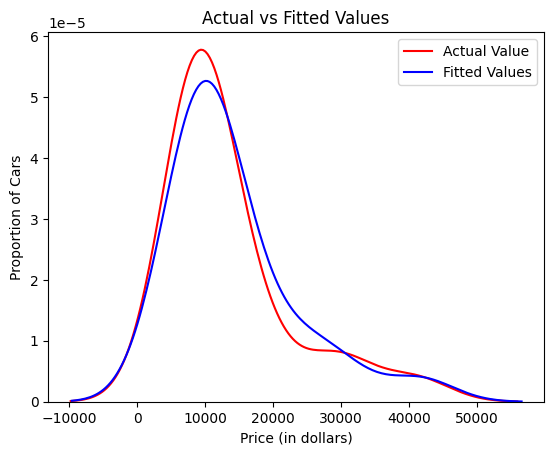

In [102]:
plot_dis(y_test,y_preds)

We can view the estimated coefficients for the linear regression problem and drop the top two coefficients, as they are two large.


In [103]:
coef_accepted = np.sort(lm.coef_)[::-1][2:]
# lm.coef_

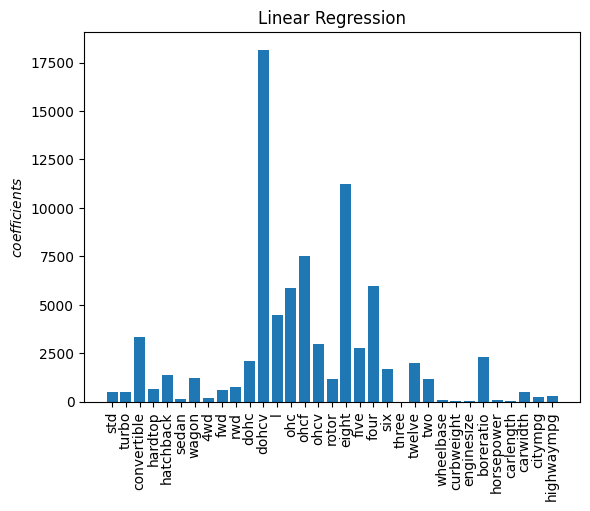

R^2 on training  data  0.9092101381197337
R^2 on testing data  0.9472499250323804


In [104]:
plot_coef(X,lm,name="Linear Regression")

## Ridge Regression


Let's review the Ridge Regression. Ridge Regression makes the prior assumption that our coefficients are normally distributed around zero. A regularization term, alpha, is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. The variance of the distribution is inversely proportional to the parameter alpha. This is also called the  L2 regularizer , as it adds a L2 penalty to the minimization term, as shown here:

$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2+ \alpha  ||\textbf{w}||_2 }$

We minimize the MSE, but we also penalize large weights by including their magnitude $||\textbf{w}||\_2$ in the minimization term. This additional minimization term makes the model less susceptible to noise and makes the weights smaller. Alpha controls the takeoff between MSE and penalization or regularization term and is chosen via cross-validation.


Let's see  how the parameter alpha changes the model. Note, here our test data will be used as validation data. Also, the regularization term should only be added to the cost function during the training.

Let's create a Ridge Regression object, setting the regularization parameter (alpha) to 0.01.


In [105]:
ridge = Ridge(alpha = 0.01)

Like regular regression, you can fit the model using the `fit()` method.


In [106]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.01)

Similarly, you can obtain a prediction:


In [107]:
ridge.predict(X_test)

array([30178.77172992, 22179.93145434, 11229.58960483, 11790.40337149,
       26348.13785546,  5439.13547145,  9054.02541015,  7265.36558563,
       10591.48456189, 10390.82134687, 17471.12024994,  7010.47430228,
       16547.06078383, 10468.27937016, 41540.38102791,  5390.34659152,
        5109.76377302, 15373.1930261 , 10703.56615831, 11448.33242702,
       10565.49269055])

We can calculate the $R^2$ on the training and testing data.


In [108]:
print("The train score is {}".format(ridge.score(X_train, y_train)))
print("The test score is {}".format(ridge.score(X_test, y_test)))


The train score is 0.9091956531801181
The test score is 0.947878461559649


Now let's compare the Ridge Regression and the Linear Regression  models. The results on the $R^2$ are about the same, and the coefficients seem to be smaller.


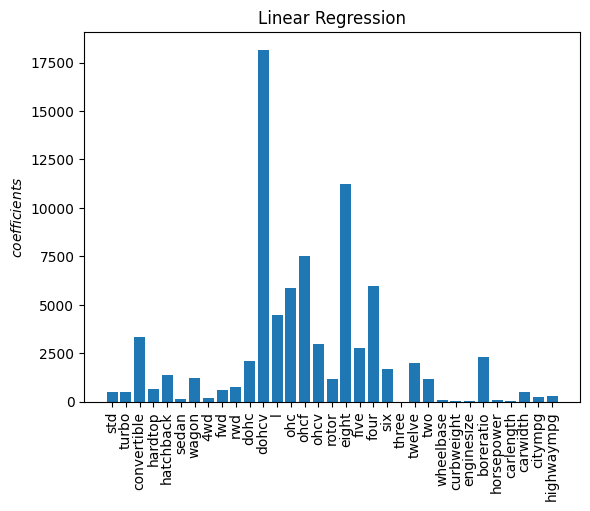

R^2 on training  data  0.9092101381197337
R^2 on testing data  0.9472499250323804


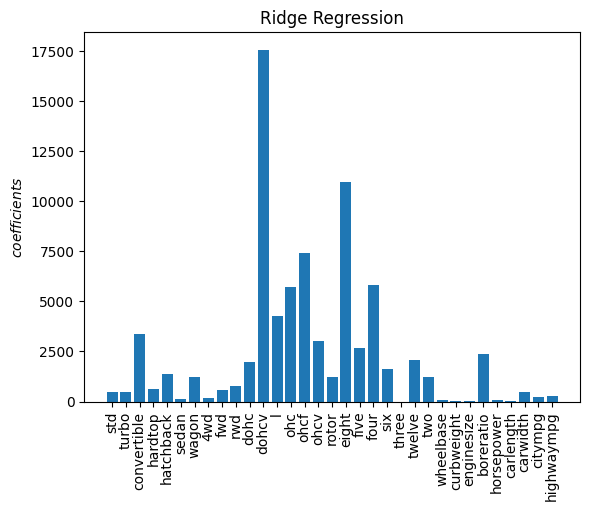

R^2 on training  data  0.9091956531801181
R^2 on testing data  0.947878461559649


In [109]:
plot_coef(X,lm,name="Linear Regression")
plot_coef(X,ridge,name="Ridge Regression")

If we increase alpha, the coefficients get smaller, but the results are not as good as our previous value of alpha.


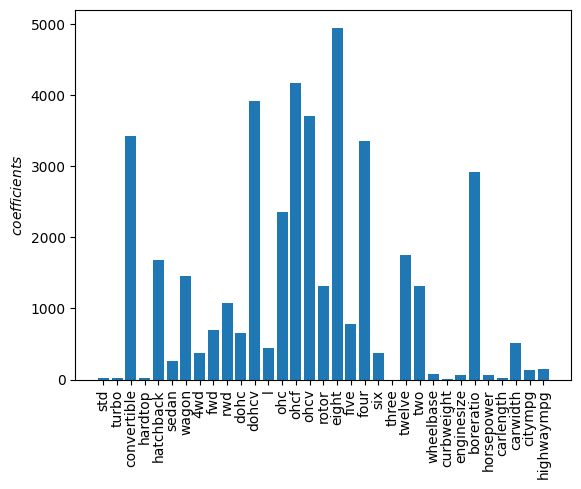

R^2 on training  data  0.8991374778636105
R^2 on testing data  0.9446031107273957


In [110]:
rr = Ridge(alpha=1)
rr.fit(X_train, y_train)
plot_coef(X,rr)

In general, we see that if we increase alpha, the coefficients get smaller, but the model performance relationship gets more complex. As a result, we use the validation data to select a value for alpha. Here, we plot the coefficients and $R^2$ of the test data on the vertical axes and alpha on the horizontal axis, as well the $R^2$ using the test data.


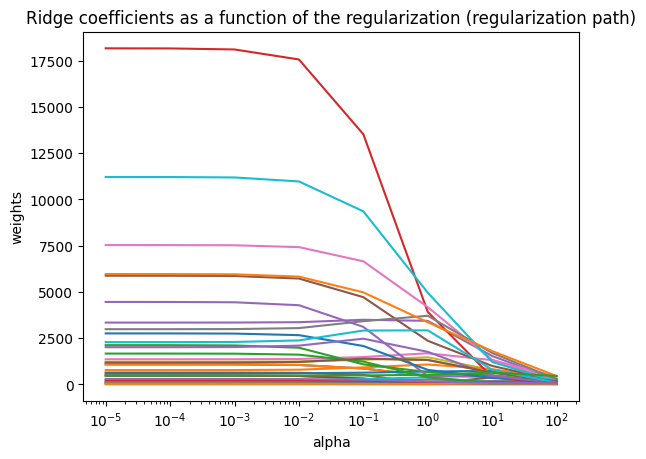

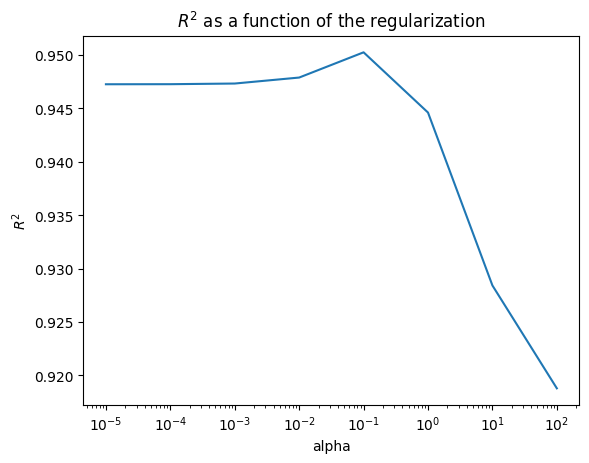

In [111]:
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
R_2=[]
coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs.append(abs(ridge.coef_))
    R_2.append(ridge.score(X_test,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()

## Exercise 1

In this Exercise, plot the MSE as a function of alpha. What pattern do you notice?


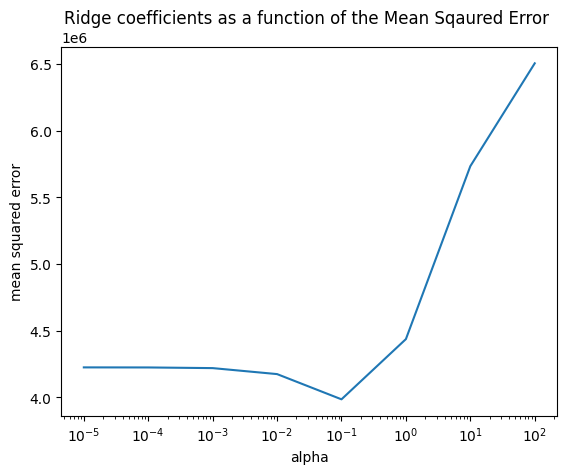

In [112]:
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
mse=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    predictions = ridge.predict(X_test)
    mse.append(mean_squared_error(y_test,predictions))


ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("mean squared error")
plt.title("Ridge coefficients as a function of the Mean Sqaured Error ")
plt.show()




We can also create a Pipeline object and apply a set of transforms sequentially. Then, we can apply Polynomial Features, perform data standardization then apply Ridge regression.  Data Pipelines simplify the steps of processing the data. We use the module `Pipeline` to create a pipeline. We also use `StandardScaler` step in our pipeline. Scaling our data is necessary step in Ridge regression as it will penalize features with a large magnitude.

Now, we create a pipeline object.


In [113]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=1))])

In [114]:
predicted=pipe.predict(X_test)
pipe.score(X_test, y_test)


0.907526221462188

##GridSearchCV

To search for the best combination of hyperparameters we can create a GridSearchCV() function as a dictionary of parameter values. The parameters of pipelines can be set by using the name of the key, separated by "__", then the parameter. Here, we look for different polynomial degrees and different values of alpha.


In [115]:
param_grid = {
    "polynomial__degree": [1,2,3,4],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10]
}



Keys of the dictionary are the model "key name __" followed by the parameter as an attribute.

polynomial__degree: is the degree of the polynomial; in this case 1, 2, 3, 4 and 5.

model__alpha : Regularization strength; must be a positive float.

We create a GridSearchCV object and fit it. The method trains the model and the hyperparameters are selected via exhaustive search over the specified values.


In [116]:
grid = GridSearchCV(pipe, param_grid, n_jobs=2)

grid.fit(X_train, y_train)
grid

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Ridge(alpha=1))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'polynomial__degree': [1, 2, 3, 4]})

**We** can input the results into *pandas* `DataFrame()` as a dictionary with keys as column headers and values as columns and display the results.


In [117]:
pd.DataFrame(grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_polynomial__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011703,0.005905,0.006386,0.004238,0.0001,1,"{'model__alpha': 0.0001, 'polynomial__degree': 1}",0.770265,0.766681,0.844321,0.873196,0.612164,0.773325,0.090599,9
1,0.014695,0.004208,0.004556,0.000238,0.0001,2,"{'model__alpha': 0.0001, 'polynomial__degree': 2}",-0.910593,0.084489,-0.549646,-0.705327,-2.630419,-0.942299,0.907235,21
2,0.083103,0.011821,0.009900,0.000708,0.0001,3,"{'model__alpha': 0.0001, 'polynomial__degree': 3}",-3.774944,-2.241587,-0.830641,-2.048391,-9.065623,-3.592237,2.892247,23
3,0.738082,0.060350,0.063220,0.008541,0.0001,4,"{'model__alpha': 0.0001, 'polynomial__degree': 4}",-6.799155,-9.100388,-0.935754,-3.845688,-8.975313,-5.931259,3.142215,24
4,0.011574,0.001576,0.004434,0.000480,0.001,1,"{'model__alpha': 0.001, 'polynomial__degree': 1}",0.770258,0.766696,0.844330,0.873212,0.612239,0.773347,0.090577,8


There are some other useful attributes:


`best_score_`: mean cross-validated score of the `best_estimator`.

`best_params_dict`: parameter setting that gives the best results on the hold-out data.


<ipython-input-93-88eac8392c06>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
<ipython-input-93-88eac8392c06>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


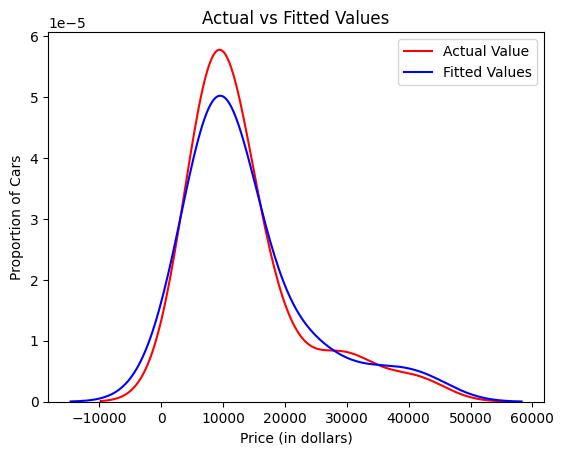

In [118]:
predict = grid.predict(X_test)

predict
plot_dis(y_test,predict)

<ipython-input-93-88eac8392c06>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
<ipython-input-93-88eac8392c06>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


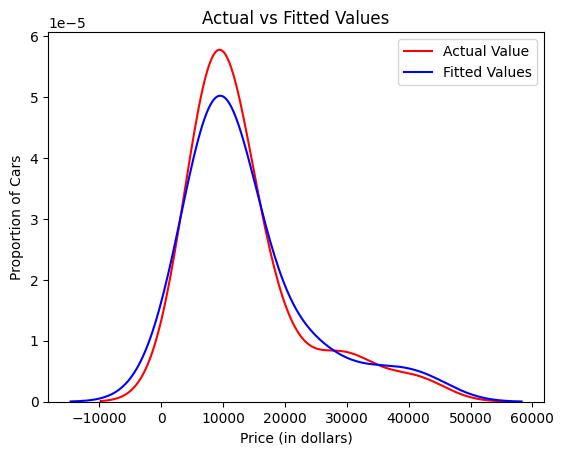

In [119]:
best=grid.best_estimator_
best

predict = best.predict(X_test)
predict

plot_dis(y_test,predict)

## Exercise 2

Perform grid search on the following features and plot the results by completing the following lines of code:


In [120]:
# Run the cell
columns=['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower',
       'carlength', 'carwidth', 'citympg']

X_col = X[columns]

X_col_train, X_col_test, y_col_train, y_col_test = train_test_split(X_col,y, test_size=0.1, random_state=42)

grid = GridSearchCV(pipe, param_grid, n_jobs=2)

grid.fit(X_col_train, y_col_train)


GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Ridge(alpha=1))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'polynomial__degree': [1, 2, 3, 4]})

<ipython-input-93-88eac8392c06>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
<ipython-input-93-88eac8392c06>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


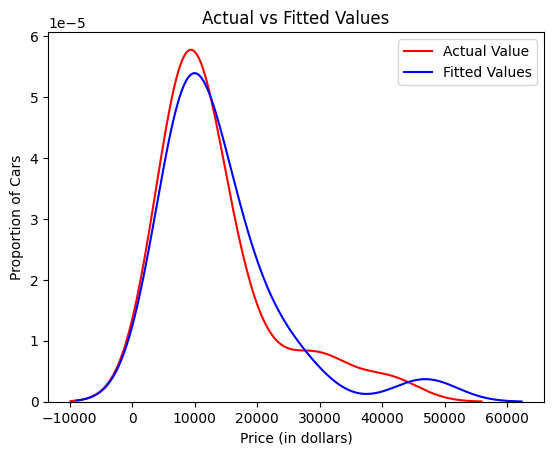

In [121]:
predict = grid.predict(X_col_test)

predict
plot_dis(y_col_test,predict)

## Lasso Regression


In this section, let's review the Lasso (Least Absolute Shrinkage and Selection Operator) Regression. Lasso Regression makes the prior assumption that our coefficients have Laplace (double-exponential) distribution around zero. The scale parameter of the distribution is inversely proportional to the parameter alpha. The main advantage of LASSO Regression is that many coefficients are set to zero, therefore they are not required. This has many advantages, one of them is that you may not need to collect and/or store all of the features. This may save resources. For example, if the feature was some medical test, you would no longer need to perform that test. Let's see how the parameter alpha changes the model.  We minimize the MSE, but we also penalize large weights by including their sum of absolute values $||\textbf{w}||_1$ , symbolically:


$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2+ \alpha  ||\textbf{w}||_1 }$

This regularization or penalty term makes many coefficients zero, making the model easy to understand and can also be used for feature selection. There are some drawbacks to this technique. It takes longer time to train and the solution may not be unique. Alpha controls the trade-off between MSE and penalization or regularization term and is chosen via cross-validation.  Let's see how the parameter alpha changes the model. Note, as before, our test data will be used as validation data. Let's create a Ridge Regression object, setting the regularization parameter (alpha) to 0.01.


In [122]:
la = Lasso(alpha=0.1)
la.fit(X_train,y_train)
la

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.103e+08, tolerance: 1.134e+06
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [123]:
predicted = la.predict(X_test)
predicted

array([30207.01664593, 22253.28978157, 11234.4293658 , 11825.51411381,
       26349.51670682,  5442.67340587,  9115.38970742,  7262.37834971,
       10602.22642602, 10426.6507622 , 17480.62216135,  6988.60683622,
       16570.42746876, 10462.5969077 , 41586.07832506,  5399.25186043,
        3317.54502062, 15367.96191917, 10698.17086097, 11451.72644684,
       10548.16668782])

In [124]:
print("R^2 on training  data ",la.score(X_train, y_train))
print("R^2 on testing data ",la.score(X_test,y_test))

R^2 on training  data  0.9092098726971481
R^2 on testing data  0.9453258869077992


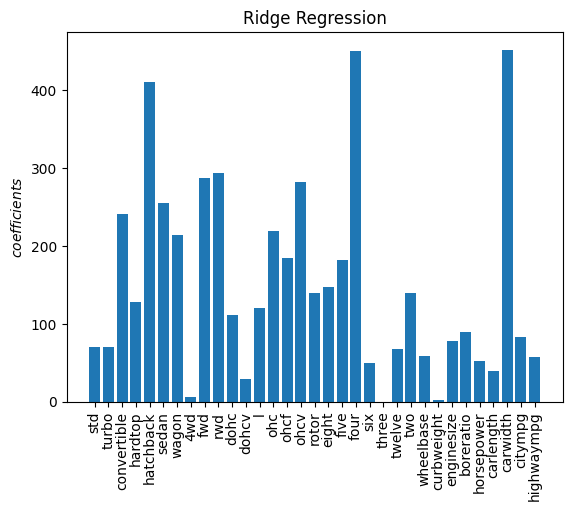

R^2 on training  data  0.8300337972702139
R^2 on testing data  0.9187896115695863


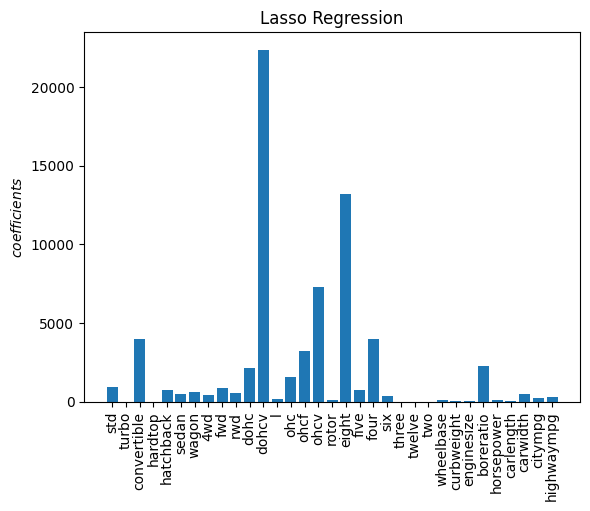

R^2 on training  data  0.9092098726971481
R^2 on testing data  0.9453258869077992


In [125]:
plot_coef(X,ridge,name="Ridge Regression")
plot_coef(X,la,name="Lasso Regression")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e+08, tolerance: 1.134e+06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e+08, tolerance: 1.134e+06
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e+08, tolerance: 1.134e

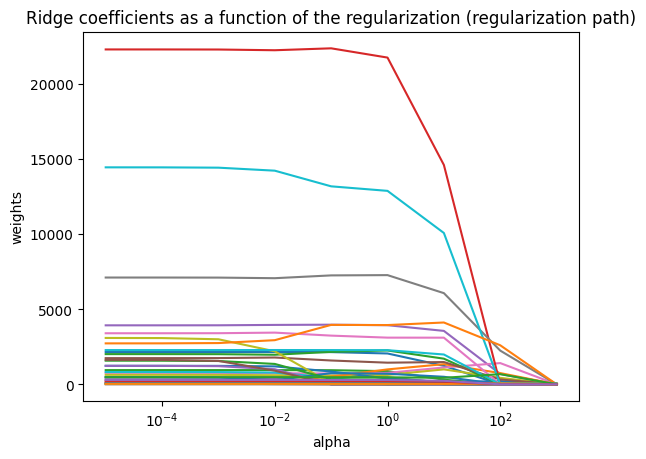

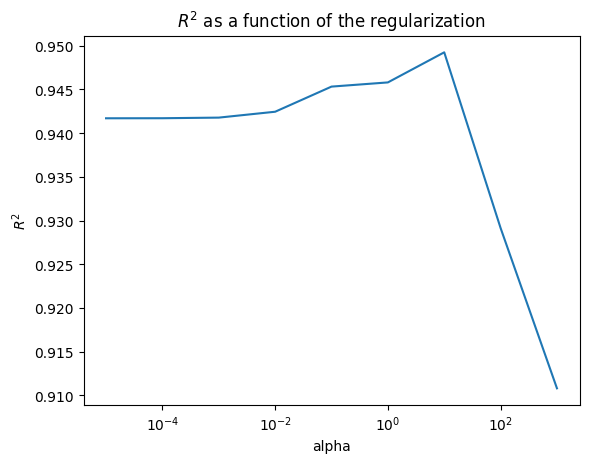

In [126]:
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
R_2=[]
coefs = []
for alpha in alphas:
    la=Lasso(alpha=alpha)

    la.fit(X_train, y_train)
    coefs.append(abs(la.coef_))
    R_2.append(la.score(X_test,y_test))


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization (regularization path)")
plt.show()


ax = plt.gca()
ax.plot(alphas, R_2)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("$R^2$")
plt.title("$R^2$ as a function of the regularization")
plt.show()

##Pipeline

We can also create a Pipeline object and apply a set of transforms sequentially. Then, we can apply polynomial features, perform data standardization, then apply Lasso Regression. We also use StandardScaler as a step in our pipeline. Scaling your data is necessary step in LASSO Regression, as it will penalize features with a large magnitudes.

We start by creating a pipeline object.


In [127]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Lasso(alpha=1, tol = 0.2))]
pipe = Pipeline(Input)

In [133]:
pipe.fit(X_train, y_train)
pipe.predict(X_test)

array([31090.35502413, 23135.62504126,  9457.4650858 , 11222.64465089,
       28503.13820242,  6821.35081552,  7716.68381925,  7436.33736593,
        7805.79226801, 10151.89082851, 16262.8074276 ,  8278.75257849,
       16684.95563795, 10658.46233607, 38313.26144272,  7039.4378737 ,
        8259.35558463, 12989.37400724,  9251.96079447,  8253.92933959,
        9674.77573004])

In [134]:
print("R^2 on training  data ",pipe.score(X_train, y_train))
print("R^2 on testing data ",pipe.score(X_test,y_test))

R^2 on training  data  0.941181185417151
R^2 on testing data  0.953382982655632


## Exercise 3

Create and fit the Elastic Net model and the Ridge Regression models and plot the coefficients for both models using the `plot_coef()`function.


In [137]:
enet = ElasticNet()
ridge = Ridge()

enet.fit(X_train, y_train)
ridge.fit(X_train,y_train)

Ridge()

Ridge Coefficient:


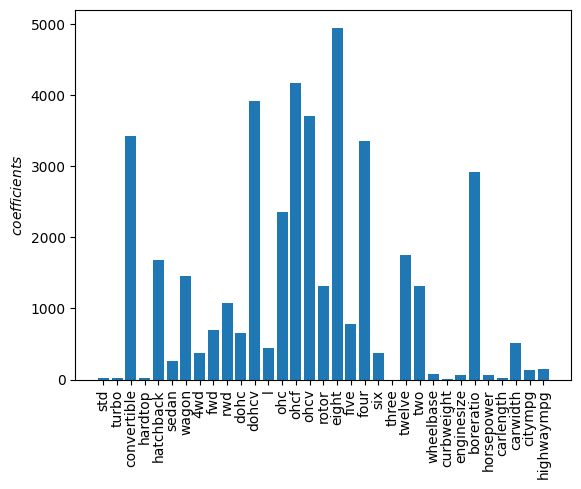

R^2 on training  data  0.8991374778636105
R^2 on testing data  0.9446031107273957
Elastic Net Coefficient:


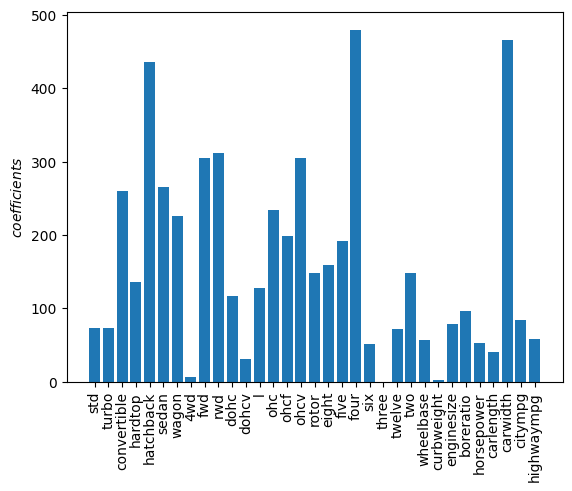

R^2 on training  data  0.8313437186732124
R^2 on testing data  0.9190099996724058


In [138]:
print("Ridge Coefficient:")
plot_coef(X,ridge)
print("Elastic Net Coefficient:")

plot_coef(X,enet)


## Exercise 4

Create a Pipeline object, apply polynomial features (degree = 2), perform data standardization, then apply Elastic Net with `alpha=0.1` and  `l1_ratio=0.1` parameters. Fit the model using the training data, then calculate the $R^2$ on the training and testing data.


In [149]:
enet_pipe_input = [("polynomial",PolynomialFeatures(degree=2)),("ss", StandardScaler()),("model",ElasticNet())]
enet_pipe = Pipeline(enet_pipe_input)

enet_pipe.fit(X_train, y_train)

print("R^2 on training  data ",enet_pipe.score(X_train, y_train))
print("R^2 on testing data ",enet_pipe.score(X_test,y_test))

R^2 on training  data  0.9568834675295073
R^2 on testing data  0.967948705928121


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e+08, tolerance: 1.134e+06
  model = cd_fast.enet_coordinate_descent(


## Exercise 5


Search for the best combination of  hyperparameters by creating  a  `GridSearchCV` object for Elastic Net Regression. Find the best parameter values using the pipeline object, as used in the above examples. Use`param_grid`, then find thee $R^2$ on the test data using the best estimator.


In [147]:
param_grid = {
    "polynomial__degree": [ 1, 2,3,4,5],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10],
    "model__l1_ratio":[0.1,0.25,0.5,0.75,0.9]
}


In [ ]:
grid = GridSearchCV(enet_pipe,param_grid,n_jobs=2)

grid.fit(X_train, y_train)
best = grid.best_estimator_
best.fit(X_train,y_train)

# print("R^2 on training  data ",enet_pipe.score(X_train, y_train))
print("R^2 on testing data ",best.score(X_test,y_test))